In [74]:
# Install necessary libraries such as statsmodels (for multicollinearity checks) and xgboost
import sys
!pip install statsmodels xgboost

In [75]:
# Import essential libraries for data handling, visualization, and machine learning
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
import pickle

In [76]:
app_data = pd.read_csv("datasets/application_record.csv")
credit_data = pd.read_csv("datasets/credit_record.csv")

In [77]:
print("Sample records from application data:")
print(app_data.sample(5))

Sample records from application data:
             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
297746  6175672           F            Y               Y             2   
232801  6239813           F            N               Y             0   
370096  6545079           F            N               N             0   
392824  6670394           M            N               N             0   
135164  5629185           M            Y               Y             1   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
297746          270000.0  Commercial associate              Incomplete higher   
232801          225000.0               Working               Higher education   
370096          130500.0               Working  Secondary / secondary special   
392824          135000.0               Working               Higher education   
135164          135000.0               Working  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAM

In [78]:
print("Sample records from credit data:")
print(credit_data.sample(5))

Sample records from credit data:
             ID  MONTHS_BALANCE STATUS
615754  5079171             -28      0
178340  5016549             -25      0
710294  5096177              -9      C
288588  5025195             -16      C
411028  5048271             -18      C


In [79]:
print('Application record shape:', app_data.shape)
print('Credit record shape:', credit_data.shape)

Application record shape: (438557, 18)
Credit record shape: (1048575, 3)


In [80]:
# Select a random ID from credit_data to inspect how credit status is recorded over time
selected_id = 5092441
print("Entries for selected ID from credit data:")
print(credit_data[credit_data['ID'] == selected_id])

Entries for selected ID from credit data:
             ID  MONTHS_BALANCE STATUS
690772  5092441              -7      C
690773  5092441              -8      C
690774  5092441              -9      C
690775  5092441             -10      C
690776  5092441             -11      C
690777  5092441             -12      C
690778  5092441             -13      C
690779  5092441             -14      C
690780  5092441             -15      C
690781  5092441             -16      C
690782  5092441             -17      C
690783  5092441             -18      C
690784  5092441             -19      C
690785  5092441             -20      C
690786  5092441             -21      C
690787  5092441             -22      C
690788  5092441             -23      C
690789  5092441             -24      C
690790  5092441             -25      C
690791  5092441             -26      C
690792  5092441             -27      C
690793  5092441             -28      C
690794  5092441             -29      C
690795  5092441       

In [81]:
# Merge application and credit datasets on 'ID' with an inner join to keep only matching records
data = pd.merge(app_data, credit_data, on='ID', how='inner')
print('Shape of merged data:', data.shape)

Shape of merged data: (777715, 20)


In [82]:
# Check for null values in merged data and their percentages
missing_values = data.isnull().sum() / data.shape[0] * 100
print("Percentage of missing values per column:\n", missing_values)

Percentage of missing values per column:
 ID                      0.000000
CODE_GENDER             0.000000
FLAG_OWN_CAR            0.000000
FLAG_OWN_REALTY         0.000000
CNT_CHILDREN            0.000000
AMT_INCOME_TOTAL        0.000000
NAME_INCOME_TYPE        0.000000
NAME_EDUCATION_TYPE     0.000000
NAME_FAMILY_STATUS      0.000000
NAME_HOUSING_TYPE       0.000000
DAYS_BIRTH              0.000000
DAYS_EMPLOYED           0.000000
FLAG_MOBIL              0.000000
FLAG_WORK_PHONE         0.000000
FLAG_PHONE              0.000000
FLAG_EMAIL              0.000000
OCCUPATION_TYPE        30.865806
CNT_FAM_MEMBERS         0.000000
MONTHS_BALANCE          0.000000
STATUS                  0.000000
dtype: float64


In [83]:
data.dropna(inplace=True)
print("Shape of dataset after dropping missing values:", data.shape)

Shape of dataset after dropping missing values: (537667, 20)


In [84]:
# Check for duplicate records to ensure data integrity
print('Duplicate records in merged data:', data.duplicated().sum())

Duplicate records in merged data: 0


In [85]:
# Map credit status to simplified categories ('Good_Debt' and 'Bad_Debt')
status_mapping = {"C": "Good_Debt", "X": "Good_Debt", "0": "Good_Debt", "1": "Good_Debt",
                  "2": "Bad_Debt", "3": "Bad_Debt", "4": "Bad_Debt", "5": "Bad_Debt"}
data['STATUS'].replace(status_mapping, inplace=True)
print("Value counts for the 'STATUS' field after transformation:")
print(data['STATUS'].value_counts())

Value counts for the 'STATUS' field after transformation:
Good_Debt    535705
Bad_Debt       1962
Name: STATUS, dtype: int64


In [86]:
 new_column_names = {
'ID': 'ID',
'CODE_GENDER': 'Gender',
'FLAG_OWN_CAR': 'Car',
'FLAG_OWN_REALTY': 'Realty',
'CNT_CHILDREN': 'Children',
'AMT_INCOME_TOTAL': 'Income',
'NAME_INCOME_TYPE': 'Income Type',
'NAME_EDUCATION_TYPE': 'Education',
'NAME_FAMILY_STATUS': 'Family',
'NAME_HOUSING_TYPE': 'Housing',
'DAYS_BIRTH': 'Birthday',
'DAYS_EMPLOYED': 'Employment',
'FLAG_MOBIL': 'Mobile Phone',
'FLAG_WORK_PHONE': 'Work Phone',
'FLAG_PHONE': 'Phone',
'FLAG_EMAIL': 'Email',
'OCCUPATION_TYPE': 'Occupation',
'CNT_FAM_MEMBERS': 'Family Member Count',
'MONTHS_BALANCE': 'Months',
'STATUS': 'STATUS'
}
data.rename(columns=new_column_names, inplace=True)


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537667 entries, 31 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   537667 non-null  int64  
 1   Gender               537667 non-null  object 
 2   Car                  537667 non-null  object 
 3   Realty               537667 non-null  object 
 4   Children             537667 non-null  int64  
 5   Income               537667 non-null  float64
 6   Income Type          537667 non-null  object 
 7   Education            537667 non-null  object 
 8   Family               537667 non-null  object 
 9   Housing              537667 non-null  object 
 10  Birthday             537667 non-null  int64  
 11  Employment           537667 non-null  int64  
 12  Mobile Phone         537667 non-null  int64  
 13  Work Phone           537667 non-null  int64  
 14  Phone                537667 non-null  int64  
 15  Email           

In [88]:
# Encode categorical variables using Label Encoding
col_names = list(data.select_dtypes('object').columns)
col_names

['Gender',
 'Car',
 'Realty',
 'Income Type',
 'Education',
 'Family',
 'Housing',
 'Occupation',
 'STATUS']

In [89]:
# Apply label encoding to specified categorical columns
label_encoders = {}

for col in col_names:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Save the entire dictionary of LabelEncoders into one file
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

In [90]:
print("Encoded sample data:")
print(data.head())


Encoded sample data:
         ID  Gender  Car  Realty  Children    Income  Income Type  Education  \
31  5008806       1    1       1         0  112500.0            4          4   
32  5008806       1    1       1         0  112500.0            4          4   
33  5008806       1    1       1         0  112500.0            4          4   
34  5008806       1    1       1         0  112500.0            4          4   
35  5008806       1    1       1         0  112500.0            4          4   

    Family  Housing  Birthday  Employment  Mobile Phone  Work Phone  Phone  \
31       1        1    -21474       -1134             1           0      0   
32       1        1    -21474       -1134             1           0      0   
33       1        1    -21474       -1134             1           0      0   
34       1        1    -21474       -1134             1           0      0   
35       1        1    -21474       -1134             1           0      0   

    Email  Occupation  Family

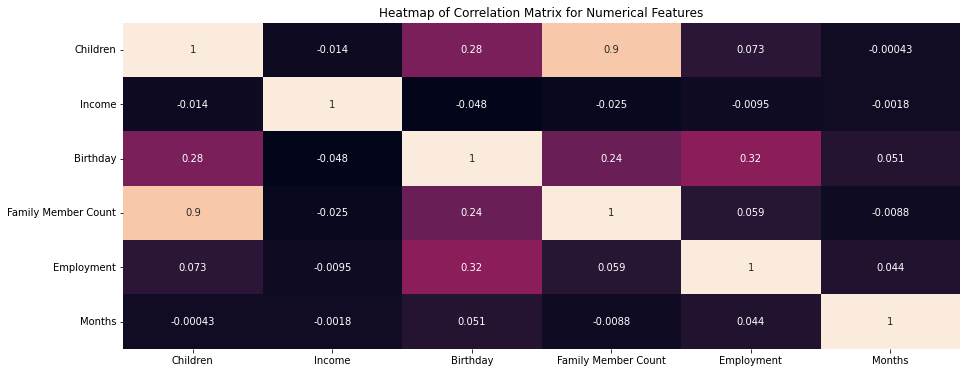

In [91]:
# Visualize the correlation matrix of numerical features to assess multicollinearity
plt.figure(figsize=(15, 6))
sns.heatmap(data[['Children', 'Income', 'Birthday', 'Family Member Count', 'Employment', 'Months']].corr(), annot=True, cbar=False)
plt.title('Heatmap of Correlation Matrix for Numerical Features')
plt.show()

In [92]:
# Compute Variance Inflation Factor (VIF) to detect multicollinearity among numerical features
vif_data = pd.DataFrame()
vif_data["Features"] = data.columns
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
print("Variance Inflation Factor (VIF) for features:\n", vif_data)

Variance Inflation Factor (VIF) for features:
                Features           VIF
0                    ID      1.022188
1                Gender      1.212764
2                   Car      1.190991
3                Realty      1.098616
4              Children     19.785182
5                Income      1.172745
6           Income Type      1.048286
7             Education      1.120733
8                Family      4.753106
9               Housing      1.065340
10             Birthday      1.297107
11           Employment      1.136783
12         Mobile Phone  15489.170112
13           Work Phone      1.245857
14                Phone      1.175084
15                Email      1.029590
16           Occupation      1.016966
17  Family Member Count     25.790742
18               Months      1.004287
19               STATUS      1.002027


In [93]:
# Drop features with high VIF values (suggesting multicollinearity) to improve model performance
data_clean = data.drop(['ID', 'Mobile Phone', 'Family Member Count', 'Children'], axis=1)

In [94]:
# Use SMOTE to balance the dataset since it is highly imbalanced
smote = SMOTE()
X_balance, Y_balance = smote.fit_resample(data_clean.drop('STATUS', axis=1), data_clean['STATUS'])

In [95]:
# Train-test split to evaluate model performance
x_train, x_test, y_train, y_test = train_test_split(X_balance, Y_balance, test_size=0.2, random_state=16)

In [96]:
# Train a Logistic Regression model and evaluate its performance
log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train, y_train);

y_predict = log_model.predict(x_test)

print('Logistic Regression - Train Accuracy:', log_model.score(x_train, y_train) * 100, '%')
print('Logistic Regression - Test Accuracy:', log_model.score(x_test, y_test) * 100, '%')

# Print performance metrics
print('\nClassification report:')
print(classification_report(y_test, y_predict))

C:\Users\rocks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Train Accuracy: 60.77272006048104 %
Logistic Regression - Test Accuracy: 60.916922559991036 %

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61    106942
           1       0.61      0.60      0.61    107340

    accuracy                           0.61    214282
   macro avg       0.61      0.61      0.61    214282
weighted avg       0.61      0.61      0.61    214282



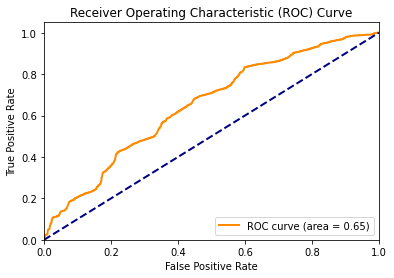

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Assuming model2 is your trained classification model
# Assuming x_test and y_test are your test features and labels, respectively
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log_model.predict_proba(x_test)[:, 1])
# Calculate AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [98]:
# Train a Random Forest model and evaluate its performance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

filename = "rf_model.pkl"
pickle.dump(rf_model, open(filename, 'wb'))

y_predict = rf_model.predict(x_test)

print('Random Forest - Train Accuracy:', rf_model.score(x_train, y_train) * 100, '%')
print('Random Forest - Test Accuracy:', rf_model.score(x_test, y_test) * 100, '%')

# Print performance metrics
print('\nClassification report:')
print(classification_report(y_test, y_predict))


Random Forest - Train Accuracy: 99.40848974715561 %
Random Forest - Test Accuracy: 99.3289217013095 %

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    106942
           1       1.00      0.99      0.99    107340

    accuracy                           0.99    214282
   macro avg       0.99      0.99      0.99    214282
weighted avg       0.99      0.99      0.99    214282



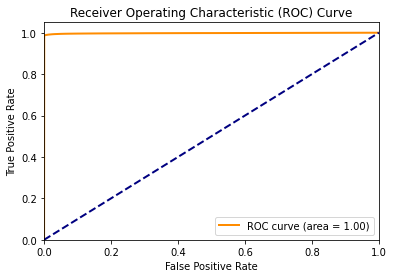

In [99]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(x_test)[:, 1])
# Calculate AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [100]:
# Train an XGBoost model and evaluate its performance
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)

y_predict = xgb_model.predict(x_test)

xgb_model.fit(x_train, y_train)
print('XGBoost - Train Accuracy:', xgb_model.score(x_train, y_train) * 100, '%')
print('XGBoost - Test Accuracy:', xgb_model.score(x_test, y_test) * 100, '%')

# Print performance metrics
print('\nClassification report:')
print(classification_report(y_test, y_predict))


XGBoost - Train Accuracy: 98.44982313026759 %
XGBoost - Test Accuracy: 98.37317180164456 %

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    106942
           1       0.99      0.98      0.98    107340

    accuracy                           0.98    214282
   macro avg       0.98      0.98      0.98    214282
weighted avg       0.98      0.98      0.98    214282



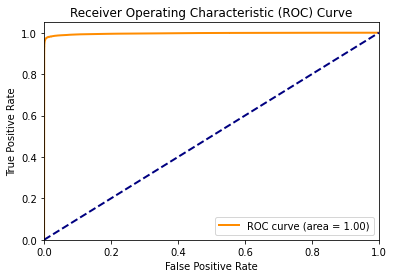

In [101]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(x_test)[:, 1])
# Calculate AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
